#### Objective

To Create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.

---To analyze user ratings, demographic data, and movie characteristics to
 understand viewing preferences.

---To apply collaborative filtering, Pearson Correlation, Cosine Similarity, and Matrix
 Factorization techniques to build an effective recommender system.




---To evaluate the system's performance and refine it for accuracy and user
 relevance.




In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [8]:
movies= pd.read_fwf('/content/zee-movies.dat', encoding='ISO-8859-1')
rate= pd.read_fwf('/content/zee-ratings.dat', encoding='ISO-8859-1')
users= pd.read_fwf('/content/zee-users.dat', encoding='ISO-8859-1')

In [9]:
movies.head()

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN


In [10]:
movies[["MovieID","Title","Genres"]]=movies["Movie ID::Title::Genres"].str.split("::",expand=True)
movies.drop(columns=['Movie ID::Title::Genres','Unnamed: 1','Unnamed: 2'], inplace=True)
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
rate.head()

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


In [12]:
rate[["UserID","MovieID","Rating","Timestamp"]]=rate["UserID::MovieID::Rating::Timestamp"].str.split("::",expand=True)

In [13]:
rate.drop(columns=['UserID::MovieID::Rating::Timestamp'], inplace=True)
rate.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [14]:
users.head()

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455


In [15]:
users[["UserID","Gender","Age","Occupation","Zip-code"]]=users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::",expand=True)

In [16]:
users.drop(columns=['UserID::Gender::Age::Occupation::Zip-code'], inplace=True)
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [17]:
Age_map={'1': "Under 18",'18': "18-24",'25': "25-34",'35': "35-44",'45': "45-49",'50': "50-55",'56': "56+"}
users['Age']=users['Age'].replace(Age_map)

In [18]:
Occupation_map={'0': "other", '1': "academic/educator",'2': "artist",'3': "clerical/admin",'4': "college/grad student",
'5': "customer service",'6': "doctor/health care",'7': "executive/managerial",'8': "farmer",'9': "homemaker",
'10': "K-12 student",'11': "lawyer",'12': "programmer",'13': "retired",'14': "sales/marketing",'15': "scientist",
'16': "self-employed",'17': "technician/engineer",'18': "tradesman/craftsman",'19': "unemployed",'20': "writer"}
users['Occupation']=users['Occupation'].replace(Occupation_map)

In [19]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,Under 18,K-12 student,48067
1,2,M,56+,self-employed,70072
2,3,M,25-34,scientist,55117
3,4,M,45-49,executive/managerial,02460
4,5,M,25-34,writer,55455


In [20]:
df=pd.merge(movies,rate, how="inner", on="MovieID")

In [21]:
dframe=pd.merge(df,users,how="inner", on="UserID")

In [22]:
dframe.head()

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,Under 18,K-12 student,48067
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008,F,50-55,homemaker,55117
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496,M,25-34,programmer,11413
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952,M,25-34,technician/engineer,61614
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474,F,35-44,academic/educator,95370


In [23]:
data=dframe.copy(deep=True)

### Exploratory Data Analysis

In [24]:
print("Rows :",data.shape[0])
print("Columns :",data.shape[1])

Rows : 1000209
Columns : 10


In [25]:
data.describe()

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
count,1000209,1000209,996144,1000209,1000209,1000209,1000209,1000209,1000209,1000209
unique,3706,3706,358,6040,5,458455,2,7,21,3439
top,2858,American Beauty (1999),Comedy,4169,4,975528402,M,25-34,college/grad student,94110
freq,3428,3428,116691,2314,348971,30,753769,395556,131032,3802


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   MovieID     1000209 non-null  object
 1   Title       1000209 non-null  object
 2   Genres      996144 non-null   object
 3   UserID      1000209 non-null  object
 4   Rating      1000209 non-null  object
 5   Timestamp   1000209 non-null  object
 6   Gender      1000209 non-null  object
 7   Age         1000209 non-null  object
 8   Occupation  1000209 non-null  object
 9   Zip-code    1000209 non-null  object
dtypes: object(10)
memory usage: 76.3+ MB


**Insights**
1.   There are 1000209 rows and 10 columns in our dataset
2.   There are total 3706	movies being rated by total 6040 users
3.   The movie that has been watched by most is American Beauty (1999) by mostly college/grad students





#### Feature Engineering

 As we can see the datatype of all features are objects and we want ratings to be iteger tyoe and timestamp to be in datetime format

In [27]:
data['Rating']=data['Rating'].astype('int32')

The timestamp  is likely a Unix timestamp, which represents the number of seconds that have elapsed since January 1, 1970 (the Unix epoch), at 00:00:00 UTC.
We Use the pd.to_datetime() function to convert the Unix timestamp into a Pandas datetime object. We specify the unit='s' parameter because the timestamp is in seconds.

In [28]:
data['Date']=pd.to_datetime(data['Timestamp'], unit='s')

Deriving new feature: ‘Release Year’

In [29]:
data['release y']=data['Title'].str.split(" ").str[-1]

In [30]:
data['release y'] = data['release y'].str.lstrip("(").str.rstrip(")")

In [31]:
data['Title'] = data['Title'].str.rsplit(' ', n=1).str[0]

In [32]:
data['release y'].unique()

array(['1995', '1994', '1996', 'the', '1976', '1993', '1992', '1988',
       '1967', '1964):', '1977', 'B', '1965', '1982', '1962', '1990',
       '1991', '1989', '1937', '1940', '1969', '1981', '1973', '1970',
       '1960', '1955', '1956', '1959', '1968', '1980', '1975', '1995):',
       '1948', '1943', 'Bo', '1950', '1987', '1997', 'Arta', '1974',
       '1958', '1972', '1998', '1952', '1951', '1957', '1961', '1954',
       '1934', '1944', '1963', '1942', '1941', '1964', '1953', '1939',
       '1947', '1946', '1945', '1938', '1935', '1936', '1926', '1949',
       '1932', '1930', '1971', '1979', '1986', '1966', '1978', '1985',
       '1983', '1984', '1933', '1931', '1922', '19', '1927', '1929',
       '195', '1928', '1999', "d'A", 'Polar', '1925', '1981):', '1919',
       '', '1923', '2000', '1', '1920', '1921', 'prendront', '1989):'],
      dtype=object)

In [33]:
correct_y={'1964):':'1964','1995):':'1995', '1981):':'1981', '1989):':'1989'}
data['release y']=data['release y'].replace(correct_y)

In [34]:
remove = data[(data['release y']=='195') |
               (data['release y']=='Bo') |
               (data['release y']=='195') |
               (data['release y']=='') |
               (data['release y']=='the') |
               (data['release y']=='Arta') |
               (data['release y']=='B') |
               (data['release y']=='19') |
               (data['release y']=='Polar') |
               (data['release y']=="d'A") |
               (data['release y']=='prendront') |
               (data['release y']=='1')].index
data.drop(index=remove, inplace=True)

In [35]:
data['release y'].unique()

array(['1995', '1994', '1996', '1976', '1993', '1992', '1988', '1967',
       '1964', '1977', '1965', '1982', '1962', '1990', '1991', '1989',
       '1937', '1940', '1969', '1981', '1973', '1970', '1960', '1955',
       '1956', '1959', '1968', '1980', '1975', '1948', '1943', '1950',
       '1987', '1997', '1974', '1958', '1972', '1998', '1952', '1951',
       '1957', '1961', '1954', '1934', '1944', '1963', '1942', '1941',
       '1953', '1939', '1947', '1946', '1945', '1938', '1935', '1936',
       '1926', '1949', '1932', '1930', '1971', '1979', '1986', '1966',
       '1978', '1985', '1983', '1984', '1933', '1931', '1922', '1927',
       '1929', '1928', '1999', '1925', '1919', '1923', '2000', '1920',
       '1921'], dtype=object)

In [36]:
data['release y']=data['release y'].astype('int32')

extract year, hour, minute, second from date column

In [37]:
data['Year'] = data['Date'].dt.year
data['Day'] = data['Date'].dt.day
data['Hour'] = data['Date'].dt.hour
data['Minute'] = data['Date'].dt.minute
data['Second'] = data['Date'].dt.second
data['is_weekend'] = data['Date'].dt.weekday >= 5

In [38]:
bins = [1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 2000]
labels = ['20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s']
data['Decade'] = pd.cut(data['release y'], bins=bins, labels=labels)

In [39]:
data.head()

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Date,release y,Year,Day,Hour,Minute,Second,is_weekend,Decade
0,1,Toy Story,Animation|Children's|Comedy,1,5,978824268,F,Under 18,K-12 student,48067,2001-01-06 23:37:48,1995,2001,6,23,37,48,True,90s
1,1,Toy Story,Animation|Children's|Comedy,6,4,978237008,F,50-55,homemaker,55117,2000-12-31 04:30:08,1995,2000,31,4,30,8,True,90s
2,1,Toy Story,Animation|Children's|Comedy,8,4,978233496,M,25-34,programmer,11413,2000-12-31 03:31:36,1995,2000,31,3,31,36,True,90s
3,1,Toy Story,Animation|Children's|Comedy,9,5,978225952,M,25-34,technician/engineer,61614,2000-12-31 01:25:52,1995,2000,31,1,25,52,True,90s
4,1,Toy Story,Animation|Children's|Comedy,10,5,978226474,F,35-44,academic/educator,95370,2000-12-31 01:34:34,1995,2000,31,1,34,34,True,90s


In [40]:
print("Rows :",data.shape[0])
print("Columns :",data.shape[1])

Rows : 997639
Columns : 19


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 997639 entries, 0 to 1000208
Data columns (total 19 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   MovieID     997639 non-null  object        
 1   Title       997639 non-null  object        
 2   Genres      996144 non-null  object        
 3   UserID      997639 non-null  object        
 4   Rating      997639 non-null  int32         
 5   Timestamp   997639 non-null  object        
 6   Gender      997639 non-null  object        
 7   Age         997639 non-null  object        
 8   Occupation  997639 non-null  object        
 9   Zip-code    997639 non-null  object        
 10  Date        997639 non-null  datetime64[ns]
 11  release y   997639 non-null  int32         
 12  Year        997639 non-null  int32         
 13  Day         997639 non-null  int32         
 14  Hour        997639 non-null  int32         
 15  Minute      997639 non-null  int32         
 16  Second

Check for Null Values

In [42]:
data.isna().sum()

,0
MovieID,0
Title,0
Genres,1495
UserID,0
Rating,0
Timestamp,0
Gender,0
Age,0
Occupation,0
Zip-code,0


In [43]:
data.dropna(inplace=True)

In [44]:
data.isna().sum()

,0
MovieID,0
Title,0
Genres,0
UserID,0
Rating,0
Timestamp,0
Gender,0
Age,0
Occupation,0
Zip-code,0


Checking for Duplicate records

In [45]:
duplicates = data.duplicated()
duplicates.sum()

0

**Insights**
1.   After Feature Engineering 9 more features were created such as release_year, hour, day, date, decade etc.
2.   There were 1495 null values in genresfeature and 45 null valurs in decade feature which were dropped as they constitute a very small amount of records compared to whole dataset



#### Visualisation

##### Distributions in Dataset

Text(0.5, 1.0, 'Ratings Distribution')

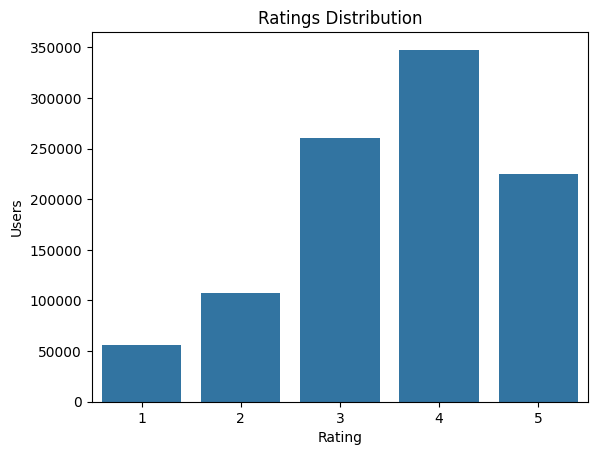

In [46]:
sns.countplot(data, x="Rating")
plt.ylabel("Users")
plt.title("Ratings Distribution")

Text(0.5, 1.0, 'Gender Distribution')

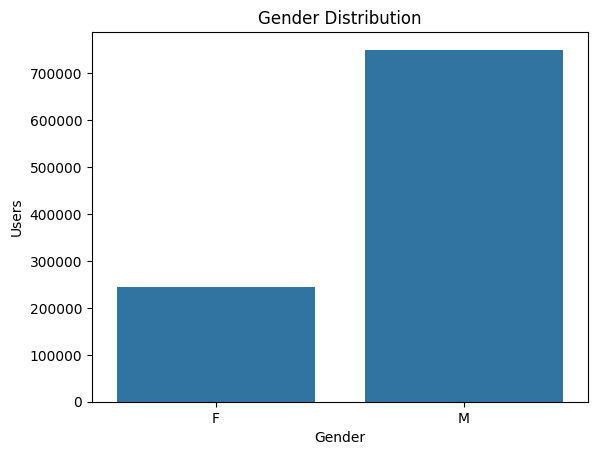

In [47]:
sns.countplot(data, x="Gender")
plt.ylabel("Users")
plt.title("Gender Distribution")

In [50]:
data['Gender'].value_counts(normalize=True)

,proportion
Gender,
M,0.75351
F,0.24649


##### Question: Most of the users in our dataset who’ve rated the movies are Male. (T/F)

From above visualisation we can say that this statement is True

Text(0.5, 1.0, 'Age Distribution')

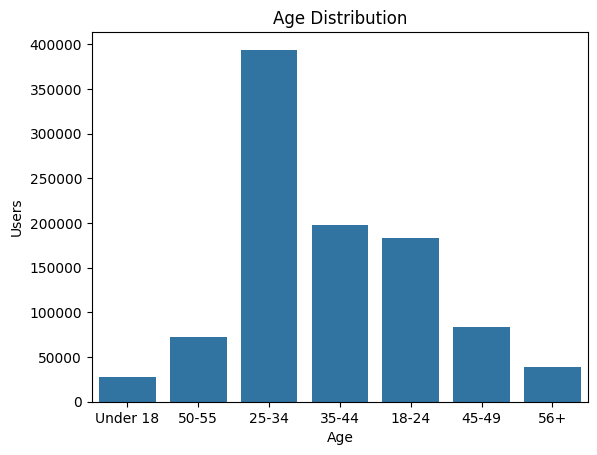

In [51]:
sns.countplot(data, x="Age")
plt.ylabel("Users")
plt.title("Age Distribution")

In [110]:
data['Age'].value_counts(normalize=True)

,proportion
Age,
25-34,0.395640
35-44,0.198852
18-24,0.183761
45-49,0.083477
50-55,0.072343
56+,0.038689
Under 18,0.027238


##### Question: Users of which age group have watched and rated the most number of movies?

From the visualisation above we can say that users of age group 25-34 have watched and rated the most number of movies

Text(0.5, 1.0, 'Occupation Distribution')

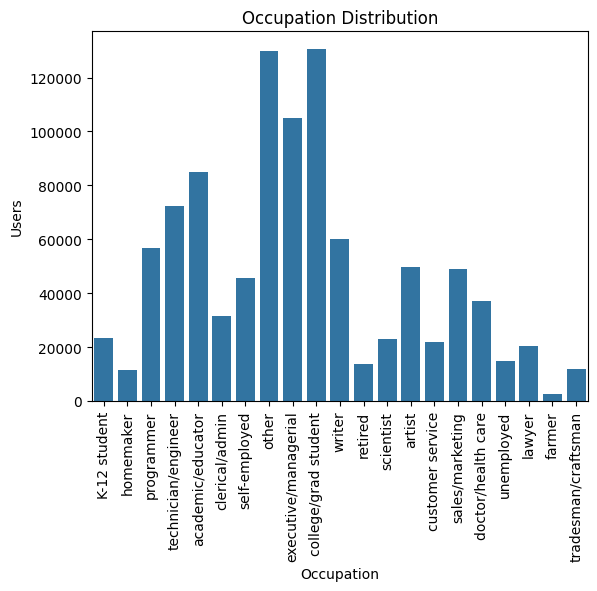

In [52]:
sns.countplot(data, x="Occupation")
plt.xticks(rotation=90)
plt.ylabel("Users")
plt.title("Occupation Distribution")

In [111]:
data['Occupation'].value_counts(normalize=True)

,proportion
Occupation,
college/grad student,0.131135
other,0.130505
executive/managerial,0.105422
academic/educator,0.085263
technician/engineer,0.072818
writer,0.060326
programmer,0.057154
artist,0.050017
sales/marketing,0.049139


##### Question: Users belonging to which profession have watched and rated the most movies?

From above visualisation we can say that userswho are college or grad Student have watched and rated most movies.

Text(0.5, 1.0, 'Decade Distribution')

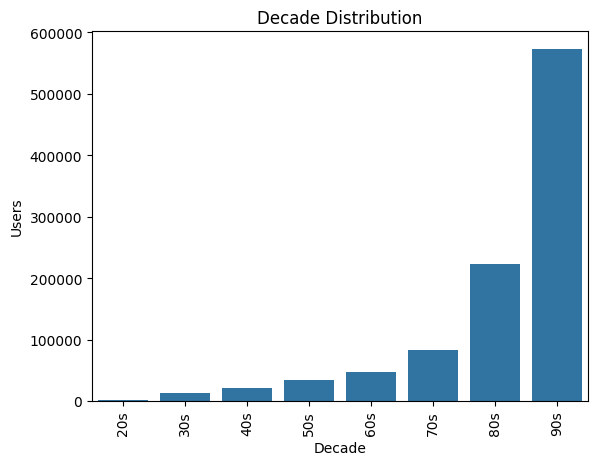

In [53]:
sns.countplot(data, x="Decade")
plt.xticks(rotation=90)
plt.ylabel("Users")
plt.title("Decade Distribution")

Text(0.5, 1.0, 'Hour Distribution')

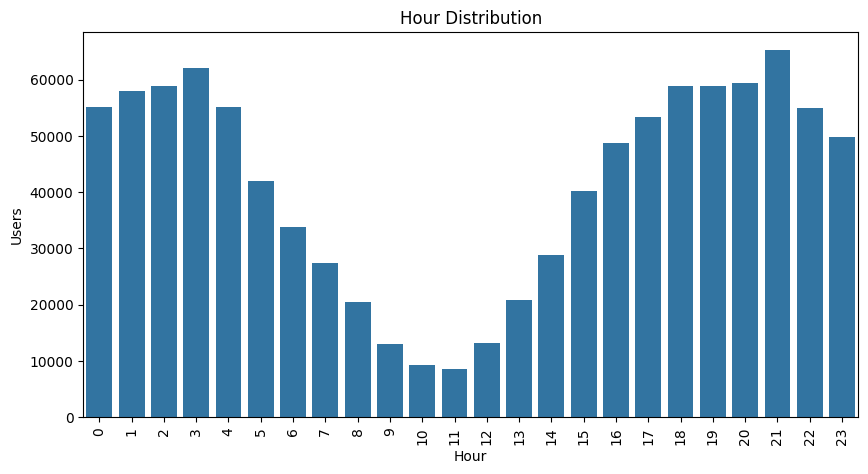

In [123]:
sns.countplot(data, x="Hour")
plt.xticks(rotation=90)
plt.ylabel("Users")
plt.title("Hour Distribution")

Text(0.5, 1.0, 'Weeekend Distribution')

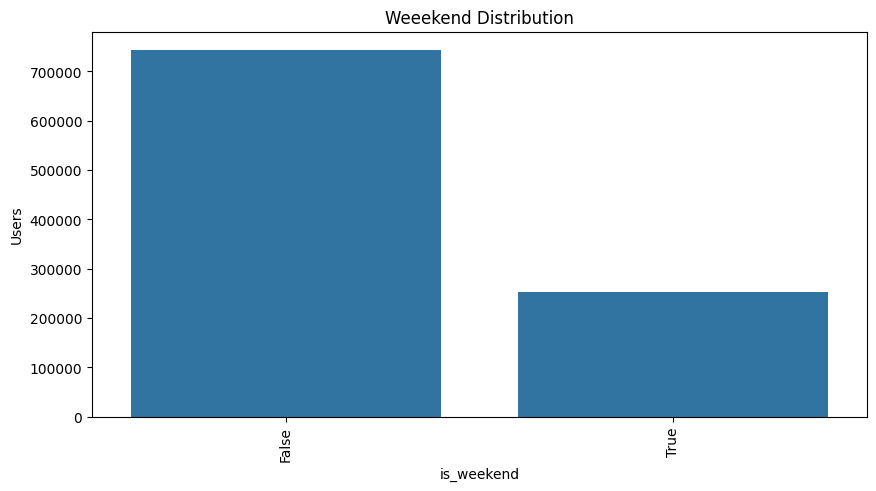

In [125]:
sns.countplot(data, x="is_weekend")
plt.xticks(rotation=90)
plt.ylabel("Users")
plt.title("Weeekend Distribution")

In [126]:
data['is_weekend'].value_counts(normalize=True)

,proportion
is_weekend,
False,0.746334
True,0.253666


<Axes: xlabel='Decade', ylabel='unique_movie_count'>

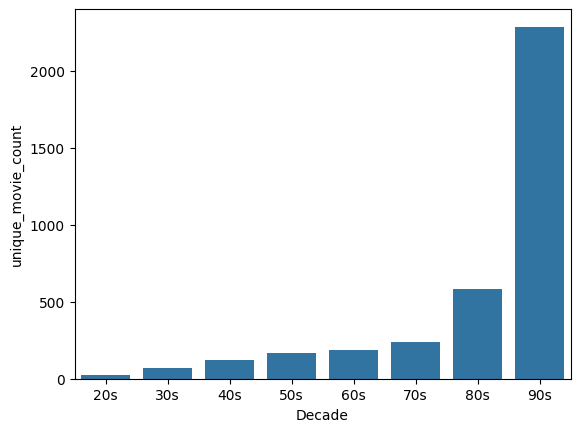

In [54]:
movies_per_dec = data.groupby('Decade')['Title'].nunique().reset_index()

# Rename the columns for clarity
movies_per_dec.columns = ['Decade', 'unique_movie_count']
sns.barplot(data=movies_per_dec, x='Decade', y='unique_movie_count')

##### Question: Most of the movies present in our dataset were released in which decade?

a. 70s, b. 90s, c. 50s, d.80s

From the data visualised above we can say that most of the movies present in our ddataset were released in 90's

**Insights**


1.   Rating 4 was given to most of the movies followed by rating 3 and rating 5.
2.   Almost 75%  of the users who watch and gave ratings were males.
3.   Almost 40% of users belong to age bracket of 25-34
4.   Most of the users are college/Grad Student
5.  most of the movies rated by users were released in the 90s
6.  Most of the movies are watched between 6 pm to 4 am
7. 75% of movies are rated on weekdays.





#### Grouping the data in terms of Average Rating and No. of Ratings given

In [55]:
avg=data.groupby('Title')['Rating'].mean().sort_values(ascending=False)
avg[:5]

,Rating
Title,
"Baby, The",5.0
"Gate of Heavenly Peace, The",5.0
Lured,5.0
Ulysses (Ulisse),5.0
Schlafes Bruder (Brother of Sleep),5.0


In [56]:
total=data.groupby('Title')['Rating'].count().sort_values(ascending=False)
total[:5]

,Rating
Title,
American Beauty,3428
Star Wars: Episode IV - A New Hope,2991
Star Wars: Episode V - The Empire Strikes Back,2990
Star Wars: Episode VI - Return of the Jedi,2883
Jurassic Park,2672


##### Question: The movie with maximum no. of ratings is ___.
As we can see The movie with maximum number of rating is American Beauty.

In [57]:
rate_df=pd.DataFrame(round(data.groupby('Title')['Rating'].mean(),2))
rate_df['counts']=pd.DataFrame(data.groupby('Title')['Rating'].count())
rate_df.head()

,Rating,counts
Title,,
"$1,000,000 Duck",3.03,37
'Night Mother,3.37,70
'Til There Was You,2.69,52
"'burbs, The",2.91,303
...And Justice for All,3.71,199


**Insights**

1.   Some of the movies having high average rating are 1)Baby, The
2) Gate of Heavenly Peace,  3)The Lured	,   4)Ulysses (Ulisse). These may have a few people who have rated these movies and given high ratings thus average ratings are high.
2.   Most rated movie is American Beauty followed by Star Wars: Episode IV - A New Hope	followed by Star Wars: Episode V - The Empire Strikes Back




#### Creating a pivot table of movie titles & user id and imputing the NaN values with a suitable value

In [58]:
pvt = pd.pivot_table(data, index='UserID', columns='Title', values='Rating', aggfunc='mean')
pvt.head()

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,5.0


In [59]:
pvt.fillna(0, inplace=True)
pvt.head()

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0


#### Pearson Correlation

In [60]:
movie=input("Enter movie Title for Recommendations: ")

Enter movie Title for Recommendations: Liar Liar


In [61]:
movie_rating = pvt[movie]
similar_movies = pvt.corrwith(movie_rating).sort_values(ascending=False)

In [62]:
similar_movies[1:4]

,0
Title,
Mrs. Doubtfire,0.499927
Dumb & Dumber,0.459601
Ace Ventura: Pet Detective,0.458654


#### Cosine Similarity

In [63]:
from sklearn.metrics.pairwise import cosine_similarity

##### User Similarity Matrix

In [64]:
user_sim = cosine_similarity(pvt)
user_similarity_df = pd.DataFrame(user_sim, index=pvt.index, columns=pvt.index)
user_similarity_df

UserID,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.255319,0.123967,0.207800,0.139317,0.110320,0.121384,0.180226,0.103896,0.052816,...,0.079367,0.038048,0.032136,0.067631,0.070052,0.035731,0.170184,0.159267,0.119356,0.122391
10,0.255319,1.000000,0.259645,0.280479,0.158703,0.112917,0.141985,0.432536,0.194915,0.102487,...,0.154412,0.186234,0.083739,0.125894,0.118558,0.146552,0.304806,0.165700,0.133327,0.248450
100,0.123967,0.259645,1.000000,0.306067,0.075736,0.110450,0.358686,0.237492,0.172872,0.099147,...,0.098235,0.097953,0.065152,0.178664,0.271311,0.033754,0.344290,0.204302,0.113522,0.306937
1000,0.207800,0.280479,0.306067,1.000000,0.099117,0.047677,0.201722,0.355920,0.325966,0.130702,...,0.170100,0.076779,0.000000,0.200343,0.380741,0.044404,0.330748,0.172803,0.098456,0.250564
1001,0.139317,0.158703,0.075736,0.099117,1.000000,0.164854,0.053887,0.150196,0.138602,0.134710,...,0.146270,0.026891,0.097011,0.119609,0.092234,0.109700,0.222119,0.103255,0.269952,0.178399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.035731,0.146552,0.033754,0.044404,0.109700,0.072578,0.031406,0.088838,0.061450,0.032265,...,0.080559,0.252222,0.074207,0.098705,0.048650,1.000000,0.063925,0.019459,0.075830,0.052571
996,0.170184,0.304806,0.344290,0.330748,0.222119,0.224779,0.185226,0.352014,0.287965,0.164045,...,0.205186,0.086546,0.062523,0.186441,0.217672,0.063925,1.000000,0.179404,0.178834,0.418466
997,0.159267,0.165700,0.204302,0.172803,0.103255,0.068980,0.170771,0.175488,0.106303,0.049536,...,0.192642,0.030588,0.081380,0.162615,0.110656,0.019459,0.179404,1.000000,0.186575,0.185639


#### Item Similarity Matrix

In [65]:
item_sim = cosine_similarity(pvt.T)
item_similarity_df = pd.DataFrame(item_sim, index=pvt.columns, columns=pvt.columns)
item_similarity_df

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck",1.000000,0.072357,0.037011,0.079291,0.060838,0.000000,0.058619,0.189843,0.094785,0.058418,...,0.038725,0.076474,0.000000,0.044074,0.0,0.045280,0.039395,0.000000,0.120242,0.027003
'Night Mother,0.072357,1.000000,0.115290,0.115545,0.159526,0.000000,0.076798,0.137135,0.111413,0.046135,...,0.053010,0.087828,0.063758,0.135962,0.0,0.091150,0.074787,0.000000,0.000000,0.077807
'Til There Was You,0.037011,0.115290,1.000000,0.098756,0.066301,0.080250,0.127895,0.128523,0.079115,0.066598,...,0.029200,0.062893,0.000000,0.079187,0.0,0.022594,0.079261,0.000000,0.047526,0.063284
"'burbs, The",0.079291,0.115545,0.098756,1.000000,0.143620,0.000000,0.192191,0.250140,0.170719,0.197808,...,0.113386,0.207897,0.019962,0.138064,0.0,0.055704,0.161174,0.000000,0.033567,0.110525
...And Justice for All,0.060838,0.159526,0.066301,0.143620,1.000000,0.000000,0.075093,0.178928,0.205486,0.122431,...,0.089998,0.153006,0.067009,0.109029,0.0,0.086080,0.110867,0.074317,0.000000,0.111040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Zed & Two Noughts, A",0.045280,0.091150,0.022594,0.055704,0.086080,0.000000,0.012702,0.042295,0.039344,0.041324,...,0.047282,0.073996,0.070409,0.141537,0.0,1.000000,0.084020,0.124939,0.000000,0.137372
Zero Effect,0.039395,0.074787,0.079261,0.161174,0.110867,0.000000,0.175771,0.157313,0.133061,0.156505,...,0.179315,0.169677,0.021362,0.206870,0.0,0.084020,1.000000,0.059228,0.016838,0.242043
Zero Kelvin (Kjærlighetens kjøtere),0.000000,0.000000,0.000000,0.000000,0.074317,0.000000,0.000000,0.033120,0.036867,0.034797,...,0.048440,0.046892,0.000000,0.000000,0.0,0.124939,0.059228,1.000000,0.000000,0.045644


###### Using the Item-based approach to create a recommender system that uses Nearest Neighbors algorithm and Cosine Similarity

In [66]:
from sklearn.neighbors import NearestNeighbors

In [67]:
model_knn = NearestNeighbors(n_neighbors=5,metric='cosine', n_jobs=-1)
model_knn.fit(item_similarity_df)

NearestNeighbors(metric='cosine', n_jobs=-1)

In [68]:
user_movie = input("Enter a movie name: ")

Enter a movie name: Liar Liar


In [69]:
movie_idx = item_similarity_df.columns.get_loc(user_movie)

In [70]:
distances, indices = model_knn.kneighbors(item_similarity_df.iloc[movie_idx, :].values.reshape(1, -1), n_neighbors=11)

In [71]:
recommended_movies = []
for i in range(1, len(distances.flatten())):  # Start from 1 to skip the movie itself
    recommended_movies.append((item_similarity_df.columns[indices.flatten()[i]], 1 - distances.flatten()[i]))

In [72]:
recommended_movies

[('Ace Ventura: Pet Detective', 0.9915054876389352),
 ('Mrs. Doubtfire', 0.9908426873415873),
 ('Dumb & Dumber', 0.9906972268433493),
 ('Home Alone', 0.9883551686313583),
 ('Wedding Singer, The', 0.9881478713846679),
 ('Grumpy Old Men', 0.9879439635281556),
 ('What About Bob?', 0.9858838062263167),
 ('Cool Runnings', 0.9858461275635766),
 ("White Men Can't Jump", 0.9857389734728681),
 ('Addams Family, The', 0.9855920446456276)]

In [73]:
#Converting it to a Dataframe

In [74]:
rec=[list(s) for s in recommended_movies]

In [75]:
recommendations=pd.DataFrame(rec,columns=['Title', 'Rating'])

In [76]:
recommendations

,Title,Rating
0,Ace Ventura: Pet Detective,0.991505
1,Mrs. Doubtfire,0.990843
2,Dumb & Dumber,0.990697
3,Home Alone,0.988355
4,"Wedding Singer, The",0.988148
5,Grumpy Old Men,0.987944
6,What About Bob?,0.985884
7,Cool Runnings,0.985846
8,White Men Can't Jump,0.985739
9,"Addams Family, The",0.985592


**Question**: Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.


The top 3 movies are

Ace Ventura: Pet Detective
Mrs. Doubtfire
Dumb & Dumber

#### Matrix Factorization

##### Using cmfrec library

In [77]:
rm = data.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
rm.head()

MovieID,1,10,100,1000,1002,1003,1004,1005,1006,1007,...,99,990,991,992,993,994,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
!pip install cmfrec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.3/268.3 kB 2.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached findblas-0.1.26.post1-py3-none-any.whl
  Created wheel for cmfrec: filename=cmfrec-3.5.1.post10-cp310-cp310-linux_x86_64.whl size=5669632 sha256=52203389759be4582c41216cbad97e99ff1540d7e235a28b862c57baf1fef338
  Stored in directory: /root/.cache/pip/wheels/cc/80/d7/9b7d9361970eb499c0227a3fac504240f7793dec0d9793bee6
Successfully built cmfrec


In [79]:
from cmfrec import CMF
from sklearn.model_selection import train_test_split


In [80]:
mat = data[['UserID', 'MovieID', 'Rating']].copy()
mat.columns = ['UserId', 'ItemId', 'Rating']  # Lib requires specific column names
mat.head(2)

,UserId,ItemId,Rating
0,1,1,5
1,6,1,4


In [81]:
train,test = train_test_split(mat, test_size=0.2, random_state=1)

In [82]:
train.shape

(796879, 3)

In [83]:
test.head()

,UserId,ItemId,Rating
823273,918,3072,4
329640,1071,1226,5
943244,3641,3624,2
732618,523,2716,3
338674,737,1242,3


In [84]:
t=test.drop(['Rating'],axis=1)

In [85]:
t.head()

,UserId,ItemId
823273,918,3072
329640,1071,1226
943244,3641,3624
732618,523,2716
338674,737,1242


In [86]:
model = CMF(method="als", k=4, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)
model.fit(mat)

Collective matrix factorization model
(explicit-feedback variant)


In [87]:
model.A_.shape, model.B_.shape

((6040, 4), (3679, 4))

In [88]:
train.Rating.mean(), model.glob_mean_

(3.5787767026110613, 3.5799906253814697)

In [89]:
from sklearn.metrics import mean_squared_error as mse

In [90]:
rm__ = np.dot(model.A_, model.B_.T) + model.glob_mean_
mse(rm.values[rm > 0], rm__[rm > 0])**0.5

1.4651148123567324

**Use embeddings for visualization and similarity-based models**

In [91]:
import keras
from tensorflow.keras.optimizers import Adam
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot
from keras.layers import dot

In [97]:
n_users = data['UserID'].nunique()
n_movies = data['MovieID'].nunique()

In [98]:
n_users

6040

In [99]:
users = data.UserID.unique()
movies = data.MovieID.unique()

userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}


In [100]:
data['UserID'] = data['UserID'].apply(lambda x: userid2idx[x])
data['MovieID'] = data['MovieID'].apply(lambda x: movieid2idx[x])
split = np.random.rand(len(data)) < 0.8
train = data[split]
valid = data[~split]
print(train.shape, valid.shape)

(796515, 19) (199584, 19)


In [101]:
user_input = Input(shape=(1, ), name='user_input', dtype='int64')
user_embedding = Embedding(n_users, output_dim=4, name='user_embedding')(user_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)

In [102]:
movie_input = Input(shape=(1, ), name='movie_input', dtype='int64')
movie_embedding = Embedding(n_movies, output_dim=4, name='movie_embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)

In [103]:
sim = dot([user_vec, movie_vec], name='Simalarity-Dot-Product', axes=1)
model = keras.models.Model([user_input, movie_input], sim)

In [104]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

In [105]:
model_final = model.fit([train.UserID, train.MovieID], train.Rating,
                       batch_size=128, epochs=20,
                       validation_data = ([valid.UserID, valid.MovieID], valid.Rating),
                       verbose=1)

Epoch 1/20
6223/6223 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 14.0579 - val_loss: 14.0477
Epoch 2/20
6223/6223 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 13.9698 - val_loss: 13.4170
Epoch 3/20
6223/6223 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 13.0621 - val_loss: 11.7238
Epoch 4/20
6223/6223 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 11.1744 - val_loss: 9.4026
Epoch 5/20
6223/6223 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 8.7788 - val_loss: 6.9503
Epoch 6/20
6223/6223 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 6.3832 - val_loss: 4.9550
Epoch 7/20
6223/6223 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 4.5573 - val_loss: 3.6735
Epoch 8/20
6223/6223 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 3.4271 - val_loss: 2.8757
Epoch 9/20
6223/6223 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 2.6968 - val_loss: 2.3422
Epoch 10/20
6223/6223 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 2.2070 - val_loss: 1.9678
Epoch 11/20
6223/6223 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 1.8606 - val_loss: 1.6992
Epoch 12/20


In [106]:
user_embedding_model = Model(inputs=user_input, outputs=user_embedding)
movie_embedding_model = Model(inputs=movie_input, outputs=movie_embedding)

In [107]:
user_embeddings = user_embedding_model.predict(np.arange(n_users))
movie_embeddings = movie_embedding_model.predict(np.arange(n_movies))

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [108]:
y_pred = model.predict([valid.UserID, valid.MovieID], verbose=0)
y_pred_class = np.argmax(y_pred, axis=-1)


RMSE

In [113]:
rmse = mse(valid.Rating, y_pred, squared=False)
print('Root Mean Squared Error: ',rmse)

Root Mean Squared Error:  0.9781247535626226


In [114]:
from sklearn.metrics import mean_absolute_percentage_error
mape =  mean_absolute_percentage_error(valid.Rating, y_pred)
print('Mean Absolute Percentage Error:',mape)

Mean Absolute Percentage Error: 0.2874455613417718


In [119]:
from pylab import rcParams

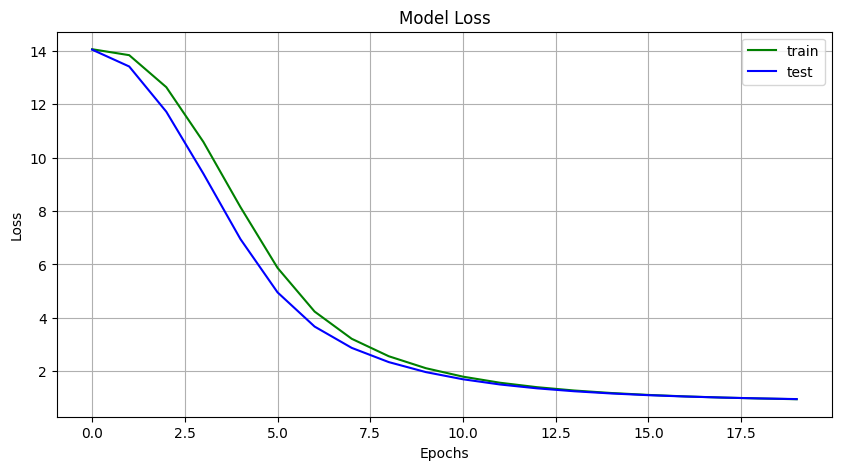

In [121]:
rcParams['figure.figsize'] = 10, 5
plt.plot(model_final.history['loss'] , 'g')
plt.plot(model_final.history['val_loss'] , 'b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.grid(True)
plt.show()

**Question:** Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model.

RMSE: 0.9786870543918464

MAPE: 0.28745118801707986

**Insights**

1.   Both Pearson corelation and cosine Similarity recommended similar movies with respect to movoe Liar Liar like Mrs. Doubtfire,  Dumb & Dumber and Ace Ventura: Pet Detective
2.   Using Matrix Factorisation we get mean squared error as 0.9786870543918464 and Mean absolute Percentage Error as 0.28745118801707986



**Question:** On the basis of approach, Collaborative Filtering methods can be classified into ___-based and ___-based.

Collaborative Filtering methods can be classified into Item-based and User-based.

**Question:** Pearson Correlation ranges between ___ to ___ whereas, Cosine Similarity belongs to the interval between ___ to ___.

Pearson Correlation ranges between -1 to 1 whereas, Cosine Similarity belongs to the interval between -1 to 1 however in the context of typical usage with non-negative vectors (like ratings), it is often considered between 0 to 1:

**Question:** Give the sparse ‘row’ matrix representation for the following dense matrix -

[[1 0]
[3 7]]

In [115]:
from scipy.sparse import csr_matrix

In [116]:
dense_matrix = np.array([[1,0], [3,7]])
sparse_matrix = csr_matrix(dense_matrix)

In [117]:
print(sparse_matrix)

  (0, 0)	1
  (1, 0)	3
  (1, 1)	7


Thus the sparse matrix will be [[0, 0, 1],
 [0, 1, 3],
 [1, 1, 7]]

**Recommendations**

1.  The recommender system should  incorporate  user feedback to to understand if recommender systrm needs improvement or is working as expected.  

2.  The  Recommender system could incorporate more advanced
 techniques such as Neural Network-based Collaborative Filtering, Recurrent Neural Networks (RNNs)

3.  The recommender System may also incorporate Probabilistic Matrix Factorization (PMF)which uses probabilistic models to handle uncertainty in ratings and improve prediction accuracy.

4.  The recommender System may also incorporate Hybrid Approaches such as Combining Collaborative and Content-Based Filtering and Context-Aware Recommender Systems if required.

5. The recommender system should be modified and updated to  adapt to changing user behaviors and preferences such as Device-Based Recommendations could be provides which Optimises recommendations for different devices (e.g., mobile, desktop, tablet).

6.  The recommender system may  create User Profiles based on demographics, preferences, and behavior to provide highly personalized recommendations.

7.  It should be  ensured that the recommendation system does not exhibit biases based on factors like gender, race, or socioeconomic status

